In [6]:
include("TypeRDS.jl")
include("Test.jl")

sampling

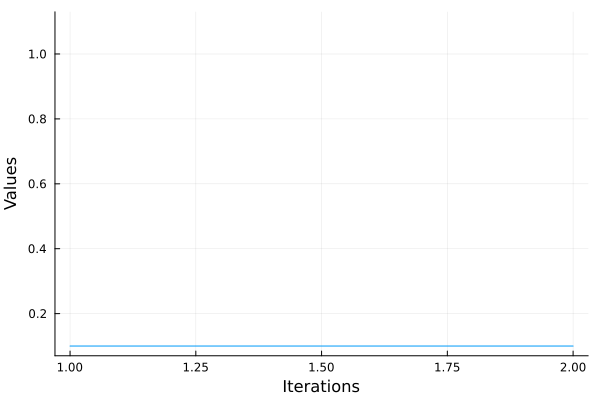

[ Info: Saved animation to c:\GT\RDS Research\RandomDynamics\tmp.gif


Float64[]

In [2]:
f(ω, x) = x
p(x) = x
rds = RDS(Interval{Closed, Closed}(0,1), 1 , Normal())
function run()
    fω(.3, [1], f)
    x=sampleTraj(rds, 1, [.1], f)
    timeseries(x, p)
    empiricalAverage(x)
    testing(x)
    tracking(x)
    sampling(1, Normal())
end
run()

The main goal is to build a Julia package that is capable of running simulations, or smaples, of random dynamical systems. The core of our package is our `Type RDS`, which will contain all  necessary information related to our random dynamical system. Below is how one instantiates a `Type RDS`.

In [4]:
struct RDS
    M::Interval                 # Phase Space M.
    SampleSpaceDimension::Int   # Dimesnion of Ω₀    
    LawOfSamples::Distribution  # Distribution of Ω₀
end

rds = RDS(Interval{Closed, Closed}(0,1), 1, Normal())

RDS(Interval{Int64, Closed, Closed}(0, 1), 1, Normal{Float64}(μ=0.0, σ=1.0))

When evaluating our random dynamical system over time, it is common for our initial data vector, $X_0$, to be sampled from a distribution. Below shows initial data vectors sampled from different distributions. We are doing this using method `sampling(n, dist)`, which takes `n` samples from distribution `dist` over the interval $[0,1]$. 

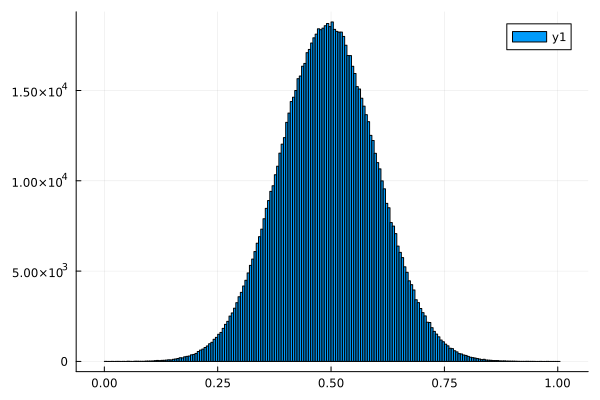

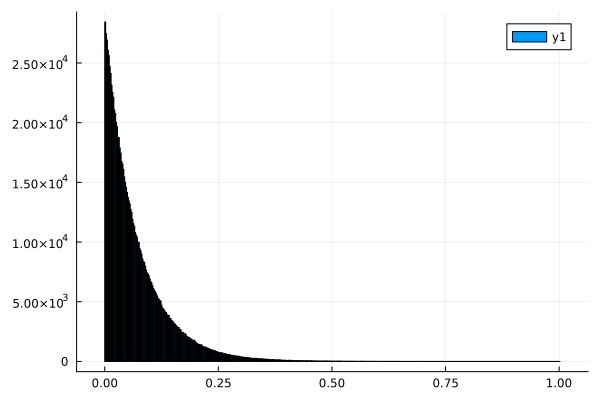

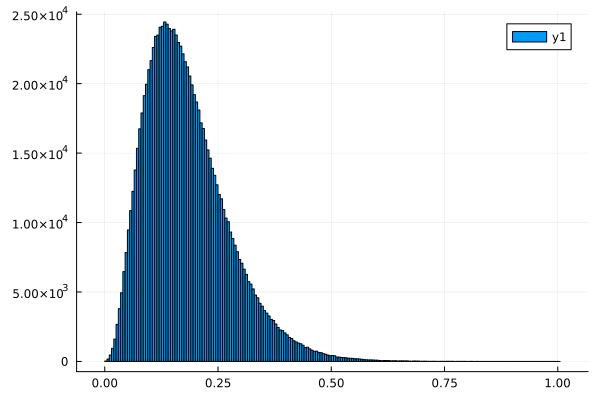

In [21]:
distributions = [Normal(), Exponential(), Chisq(8)]
for dist in distributions
    display(histogram(sampling(1000000, dist)))
end

As far as evolving our initial data overtime, we will be interested in the following composition:
$$f^n = f_{\omega_n} \circ \cdots \circ f_{\omega_1}: M \to M$$
where $f: \Omega_0 \times M \to M, (\omega, x) \mapsto f_\omega(x)$. If the $\omega_i$ are IID, then the sequence of R.V.
$$X_n = f_{\omega_n}(X_{n-1})$$
forms a Markov chain on M. $f_{\omega_i}$ is what is moving our random dynamical system forward.

## Sampling
It would be helpful to have a method that samples a trajectory of a RDS through n iterations. That is what `sampleTraj` is used for. It takes in four parameters:
- `System:RDS`: Our random dynamical system.
- `n::Int64`: Length of wanted trajectory.
- `x0`: Initial data vector.
- `func::Function`: $f_\omega$

Here are some sample traejctory demos using the same distributions as above. After we run `sampleTraj`, we will run a method `tracking` which will produce a gif displaying the evolution of our system!

[ Info: Saved animation to c:\GT\RDS Research\RandomDynamics\tmp.gif


Plots.AnimatedGif("c:\\GT\\RDS Research\\RandomDynamics\\tmp.gif")
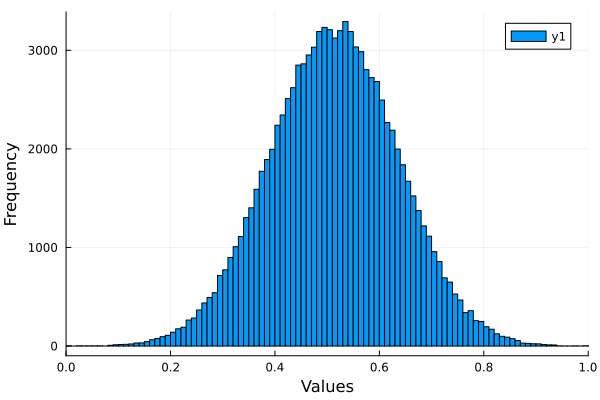

In [7]:
x0 = sampling(100000, Normal())
function f(ω::Float64, x::Float64)
    return mod(ω, 1) * x
end

traj = sampleTraj(rds, 10, x0, f)
tracking(traj)

This analytically checks out! Starting with $X_0$, every value is multiplied by the constant $0 < \omega$ mod $1<1$. So 
$$X_1 \sim \text{Norm}(c\mu, c^2\sigma^2)$$ 
where $c = \omega$ mod 1. So we expect our mean and standard deviation to decrease. As $n \to \infty,$ we have 
$$X_n \sim 0.$$

[ Info: Saved animation to c:\GT\RDS Research\RandomDynamics\tmp.gif


Plots.AnimatedGif("c:\\GT\\RDS Research\\RandomDynamics\\tmp.gif")
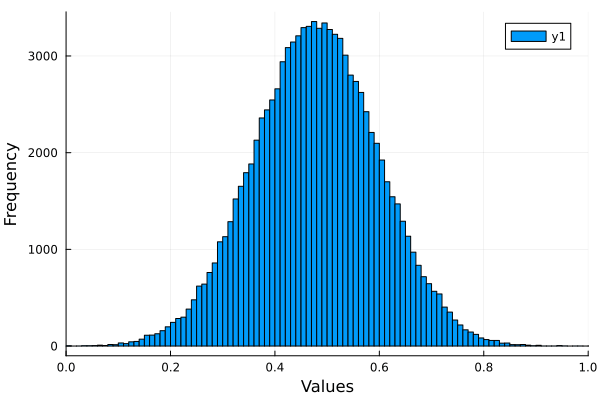

In [17]:
x0 = sampling(100000, Normal())
function f(ω::Float64, x::Float64)
    return x + (mod(ω, 1) / 5)
end

traj = sampleTraj(rds, 10, x0, f)
tracking(traj)

Let $\phi: M \to \mathbb{R}$. This is known as an observable on our phase space $M$. Given a trajectory throough $n$ iterations, the sequence
$$\{\phi(X_i)\}_{i=0}^n$$
is known as a time series. The average
$$\frac{1}{n}\sum_{i= 0}^{n-1}\phi(X_i)$$
is known as the $n^{th}$ empirical average. It is important for users to have functions that can do these computations for a given random dynamical system. So we built, `timeseries()` and `empiricalAvgs()` to do these computations.

`timeseries` has two parameters, 
- `traj::AbstractVector`: Provided trajectory,
- `ϕ::Function`: A function to apply to each data point.

`empiricalAverages` takes in one parameter, that being the trajectory we want to find the empirical average of.